# Complex graph pipeline example

In this scenario, we will create a complex pipeline for data collection with cycles and conditional execution.

We assume, you already completed the graph_tutorial.ipynb notebook and know the basics of the complex graph pipeline creation.

This pipeline should:
- execute a ping command to 8.8.8.8 and measure the average latency
- if average latency is higher than 2ms -> run an ookla speedtest (2ms is a very low threshold, but we want to see the speedtest results)
- in any case, sleep for 60 seconds 
- repeat the above steps 10 times

All the tasks except "if average latency is higher than 100ms" are implemented in netUnicorn library. We will create a custom task for the conditional execution that will return Failure if the latency is higher and Success otherwise.

In [1]:
from netunicorn.base import Task, Success, Failure
from returns.pipeline import is_successful
from netunicorn.library.tasks.measurements.ping import PingResult

class CheckLatency(Task):
    def __init__(self, latency_threshold: int, ping_task_name: str, *args, **kwargs):
        self.latency_threshold = latency_threshold
        self.ping_task_name = ping_task_name  # we need to know which task to get the results from
        super().__init__(*args, **kwargs)

    def run(self):
        # get the results from the last execution of this task
        print(self.previous_steps)
        ping_results = self.previous_steps[self.ping_task_name][-1]
        
        # if something went wrong - just skip
        if not is_successful(ping_results):
            return Success(None)
        
        data: PingResult = ping_results.unwrap()  # we know that output is PingResult class
        if data.avg_rtt > self.latency_threshold:
            return Failure(f"Observed {data.avg_rtt}ms latency, which is higher than {self.latency_threshold}ms")
        else:
            return Success(None)

Now let's import other tasks and create our pipeline

In [2]:
from netunicorn.base import ExecutionGraph
from netunicorn.library.tasks.measurements.ping import PingLinuxImplementation
from netunicorn.library.tasks.measurements.ookla_speedtest import SpeedTestLinuxImplementation
from netunicorn.library.tasks.basic import SleepTask

# we're using more complex structure, ExecutionGraph, to express the pipeline
pipeline = ExecutionGraph()

ping_task = PingLinuxImplementation(address="8.8.8.8", count=3, name="ping_task")
check_task = CheckLatency(latency_threshold=2, ping_task_name="ping_task", name="check_latency")
speedtest_task = SpeedTestLinuxImplementation(name="ookla_speedtest")
sleep_task = SleepTask(seconds=60, name="sleep_task")

pipeline.graph.add_edge("root", ping_task)
pipeline.graph.add_edge(ping_task, check_task)

# we go to the speedtest only if the latency is high (check_task returned failure)
pipeline.graph.add_edge(check_task, speedtest_task, traverse_on="failure")

# we go from check_task to sleep_task in any case, but only 10 times in total
pipeline.graph.add_edge(check_task, sleep_task, traverse_on="any", counter=9)

# and now we close the cycle
pipeline.graph.add_edge(sleep_task, "root", type="weak")

Execution graph is valid: True


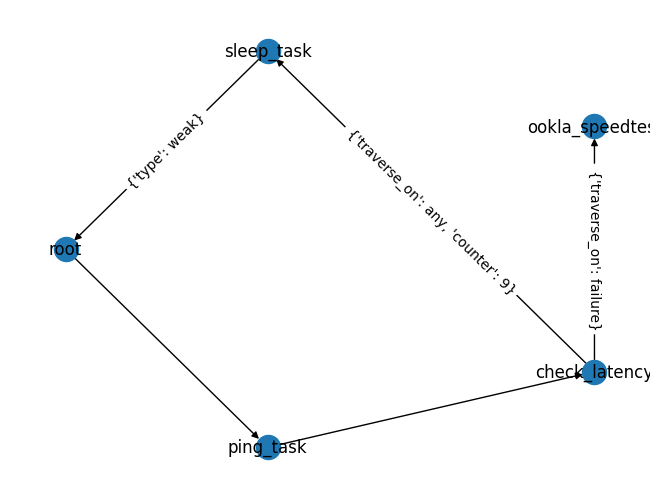

In [3]:
# let's verify that the pipeline is valid
print(f"Execution graph is valid: {ExecutionGraph.is_execution_graph_valid(pipeline)}")

# and draw it
pipeline.draw()

All other steps are not different from the basic example - we need to execute this pipeline.

Let's do it on the local machine using the local executor example.

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
from netunicorn.executor import get_local_executor

executor = get_local_executor(pipeline)

INFO:executor_local:Parsed configuration: Gateway located on fake
INFO:executor_local:Current directory: /home/kell/repos/netunicorn/examples


In [6]:
executor()

INFO:executor_local:Removed edge <__main__.CheckLatency with name check_latency> -> <netunicorn.library.tasks.basic.SleepTask with name sleep_task>
INFO:executor_local:Execution is finished, start reporting results.
INFO:executor_local:Skipping reporting results due to execution graph setting.


In [7]:
results = executor.execution_graph_results
results = results.unwrap() if is_successful(results) else results.failure()
try:
    for task_name, task_results in results.items():
        print(f"Task {task_name} results:")
        for result in task_results:
            print("\t" + str(result))
            print()
except Exception as e:
    print(e)
    print(executor.execution_graph_results)

Task ping_task results:
	<Success: PingResult(host='8.8.8.8', packets=[PacketResult(icmp_seq=1, ttl=60, time=3.17, unit='ms'), PacketResult(icmp_seq=2, ttl=60, time=3.05, unit='ms'), PacketResult(icmp_seq=3, ttl=60, time=3.16, unit='ms')], packet_loss=0.0, min_rtt=3.051, avg_rtt=3.126, max_rtt=3.169, stddev_rtt=0.053, unit_rtt='ms', unparsed_output=[], raw_output='PING 8.8.8.8 (8.8.8.8) 56(84) bytes of data.\n64 bytes from 8.8.8.8: icmp_seq=1 ttl=60 time=3.17 ms\n64 bytes from 8.8.8.8: icmp_seq=2 ttl=60 time=3.05 ms\n64 bytes from 8.8.8.8: icmp_seq=3 ttl=60 time=3.16 ms\n\n--- 8.8.8.8 ping statistics ---\n3 packets transmitted, 3 received, 0% packet loss, time 2003ms\nrtt min/avg/max/mdev = 3.051/3.126/3.169/0.053 ms\n\n')>

	<Success: PingResult(host='8.8.8.8', packets=[PacketResult(icmp_seq=1, ttl=60, time=3.02, unit='ms'), PacketResult(icmp_seq=2, ttl=60, time=3.09, unit='ms'), PacketResult(icmp_seq=3, ttl=60, time=3.1, unit='ms')], packet_loss=0.0, min_rtt=3.021, avg_rtt=3.07, max_